# 1. ALL FUNCTIONS (please do not change anything)

In [1]:
# Install packages
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

### Preparing the Dataset

In [2]:
# Code for data preparation
def data_preparation(dataset, relevant_columns):
    df_main = dataset.copy()
    df_main.replace(["", "-", "0"], np.nan, inplace=True)   # Convert potential empty strings or placeholders into NaN
    #df_main = df_main.dropna(subset=relevant_columns)       # Remove missing values
    df_main.reset_index(drop=True, inplace=True)

    # Apply Standardization (Z-score normalization)
    #scaler = StandardScaler()
    #df_main[relevant_columns] = scaler.fit_transform(df_main[relevant_columns])

    return df_main

### Correlation Analysis

In [3]:
# Function to plot correlation matrix
def correlation_matrix(var, df):
    # Compute the correlation matrix
    variables_corr = df[var]
    corr_matrix = variables_corr.corr()

    # Plot the correlation matrix with numbers inside each block
    fig, ax = plt.subplots(figsize=(26, 20))
    cax = ax.matshow(corr_matrix, cmap='coolwarm')
    
    # Adding numbers inside each cell
    for (i, j), val in np.ndenumerate(corr_matrix):
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')
        
    # Adding color bar and labels
    plt.colorbar(cax)
    ax.set_xticks(range(len(corr_matrix.columns)))
    ax.set_yticks(range(len(corr_matrix.index)))
    ax.set_xticklabels(corr_matrix.columns, rotation=45)
    ax.set_yticklabels(corr_matrix.index)
    plt.title("Correlation Matrix with Numbers", pad=20)
    
    plt.show()

### Support Vector Method (LINEAR) + RFE

### Elastic Net = Lasso + Ridge (LINEAR)

In [4]:
# Function to fit with Elastic Net (Lasso+Ridge)
def elastic_net_fit_all(X, y, split_data=False, test_size=0.3, random_state=42):

    # Optionally split dataset
    if split_data:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        print(f"Training Set Size: {X_train.shape[0]} rows")
        print(f"Test Set Size: {X_test.shape[0]} rows")
    else:
        X_train, y_train = X, y
        X_test, y_test = None, None  # No test set in this case

    # Define the Elastic Net model
    elastic_net = ElasticNet(max_iter=1000000)

    # Perform grid search to tune hyperparameters
    param_grid = {
        'alpha': [0.1, 1, 10],  # Regularization strength
        'l1_ratio': [0.1, 0.5, 0.9]  # Mix of Lasso and Ridge (alpha in formula)
    }
    grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error')

    # Fit the model to the data
    EN_model_all = grid_search.fit(X_train, y_train)

    # Best estimators based on best hyperparameters
    EN_hyperparams = EN_model_all.best_estimator_
    print("Best Hyperparameters:", EN_model_all.best_params_)

    # Coefficients of the selected model
    EN_coeff_all = EN_hyperparams.coef_
    EN_coeff_nonzero = EN_coeff_all[EN_coeff_all != 0]

    # Print coefficients with variable names if x is a DataFrame
    if hasattr(X_train, 'columns'):
        feature_names = X_train.columns
    else:
        feature_names = [f'Feature_{i}' for i in range(len(EN_coeff_all))]  # Default to generic names

    # Print feature names and their corresponding coefficients
    print("\nAll Feature Coefficients (before refit):")
    for feature, coef in zip(feature_names, EN_coeff_all):
        print(f"{feature}: {coef:.4f}")

    # Check convergence
    if hasattr(EN_model_all, 'n_iter_'):
        print(f"Elastic Net converged in {EN_model_all.n_iter_} iterations.")
    else:
        print("Convergence information not available.")
    
    # Return values based on split mode
    if split_data:
        return X_train, X_test, y_train, y_test, EN_hyperparams, EN_coeff_all, EN_coeff_nonzero, EN_model_all
    else:
        return EN_hyperparams, EN_coeff_all, EN_coeff_nonzero, EN_model_all


# Function to select features from Elastic Net
def elastic_fit_select(x, y, EN_hyperparams, X_train=None, X_test=None, y_train=None, n_features=2):

    # Apply Recursive Feature Elimination (RFE)
    rfe = RFE(estimator=EN_hyperparams, n_features_to_select=n_features)

    # Only transform test data if data was splitted before
    if X_train is not None and X_test is not None and y_train is not None:
        rfe.fit(X_train, y_train)
        X_train_rfe = rfe.transform(X_train)
        X_test_rfe = rfe.transform(X_test)
        X_rfe = rfe.transform(x)
    else:
        rfe.fit(x, y)
        y_train = y
        X_train_rfe = rfe.transform(x)
        X_test_rfe = None
        X_rfe = None

    # Select feature indices from RFE
    selected_indices = np.where(rfe.support_)[0]

    # Map indices to actual feature names if available
    if hasattr(x, 'columns'):
        selected_feat_EN = x.columns[selected_indices].tolist()
    else:
        selected_feat_EN = selected_indices.tolist()  # Return indices if no feature names

    # Retrain Elastic Net on selected features
    EN_retrained = ElasticNet(alpha=EN_hyperparams.alpha, l1_ratio=EN_hyperparams.l1_ratio, max_iter=10000)
    EN_model_refit = EN_retrained.fit(X_train_rfe, y_train)
    EN_best_coeff = EN_model_refit.coef_

    print(f"\nSelected Features (after refit): {selected_feat_EN}")
    print(f"Selected Feature Coefficients (after refit): {EN_best_coeff}")

    # Check convergence
    if hasattr(EN_model_refit, 'n_iter_'):
        print(f"Elastic Net converged in {EN_model_refit.n_iter_} iterations.")
    else:
        print("Convergence information not available.")

    # Return values based on split mode
    if X_train is not None and X_test is not None and y_train is not None:
        return selected_feat_EN, X_train_rfe, X_test_rfe, X_rfe, EN_model_refit, EN_best_coeff
    else:
        return selected_feat_EN, X_train_rfe, EN_model_refit, EN_best_coeff


# Function to predict EN
def elastic_predict(X_test_rfe, y_test, EN_model_refit):
    # Make predictions on the test data
    y_pred = EN_model_refit.predict(X_test_rfe)

    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

    return y_pred

### Support Vector Method with Radial Basis Kernel (NON-LINEAR)

In [5]:
from sklearn.inspection import permutation_importance

# Function voor nonlinear SVM
def SVM_nonlinear_select_fit(X, y, n_features=2, split_data=False, test_size=0.3, random_state=42):
    
    # Optionally split dataset
    if split_data:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        print(f"Training Set Size: {X_train.shape[0]} rows")
        print(f"Test Set Size: {X_test.shape[0]} rows")    
    else:
        X_train, y_train = X, y
        X_test, y_test = None, None  # No test set in this case

    # Hyperparameter tuning using GridSearchCV
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 0.01, 0.1],
        'epsilon': [0.01, 0.1, 0.2]
    }
    svr = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5, scoring='r2', n_jobs=-1)

    # Fit the model on the training data
    svr.fit(X_train, y_train)
    best_svr = svr.best_estimator_
    print("Best Hyperparameters:", svr.best_params_)
    
    # Compute feature importance using permutation importance
    perm_importance = permutation_importance(best_svr, X_train, y_train, scoring='r2', n_repeats=10, random_state=random_state)
    
    # Get the top n_features based on importance scores
    sorted_idx = perm_importance.importances_mean.argsort()[::-1][:n_features]
    selected_features = sorted_idx

    # Transform the dataset to only include selected features
    X_train_rfe = X_train.iloc[:, selected_features]

    # Only transform test data if split_data is True
    if split_data:
        X_test_rfe = X_test.iloc[:, selected_features]
        X_rfe = X.iloc[:, selected_features]
    else:
        X_test_rfe = None
        X_rfe = None

    # Selected features
    print("Selected Features Indices (after permutation importance):", selected_features)

    # Map indices to actual feature names if available
    if hasattr(X_train, 'columns'):
        select_feat_SVM = X_train.columns[selected_features]
        print("Selected Features Names (after permutation importance):", select_feat_SVM)

    # Fit the model to the training data
    svr_nonlinear = SVR(kernel='rbf', C=best_svr.C, epsilon=best_svr.epsilon, gamma=best_svr.gamma)
    svr_nonlinear = svr_nonlinear.fit(X_train_rfe, y_train)

    # Return values based on split mode
    if split_data:
        return X_train, X_test, y_train, y_test, X_train_rfe, X_test_rfe, X_rfe, select_feat_SVM, svr_nonlinear, perm_importance
    else:
        return X_train_rfe, select_feat_SVM, svr_nonlinear, perm_importance
    

# Function to predict
def predict_SVM_nonlinear(X_test_rfe, y_test, svr_nonlinear):
    # Make predictions on the test data
    y_pred = svr_nonlinear.predict(X_test_rfe)

    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

    return y_pred


# Function to visualize feature importances nonlinear SVM (optional)
def visualize_feature_nonlinear_SVM(select_feat_SVM, perm_importance):
    # Extract importance values
    selected_importance_values = perm_importance.importances_mean[perm_importance.importances_mean.argsort()[::-1][:len(select_feat_SVM)]]
    
    # Plot feature importances
    plt.bar(select_feat_SVM, selected_importance_values)
    plt.xlabel('Feature Name')
    plt.ylabel('Permutation Importance Score')
    plt.title('Feature Importances (Non-Linear SVM - RBF Kernel)')
    plt.xticks(rotation=45)
    plt.show()

### Validation plots & Cross-validation

In [6]:
from sklearn.model_selection import cross_val_score

# Function to visualize feature importances linear SVM (optional)
def visualize_feature_importances_SVM(select_feat_SVM, SVM_coeff):
    plt.bar(select_feat_SVM, SVM_coeff)
    plt.xlabel('Feature Name')
    plt.ylabel('Coefficient Value')
    plt.title('Feature Importances (SVM)')
    plt.show()

# Function to visualize feature importances EN (optional)
def visualize_feature_importances_EN(select_feat_EN, EN_best_coeff):
    plt.bar(select_feat_EN, EN_best_coeff)
    plt.xlabel('Feature Name')
    plt.ylabel('Coefficient Value')
    plt.title('Feature Importances (Elastic Net)')
    plt.tight_layout()
    plt.show()

# Function to plot actual vs prediction results (optional)
def plot_pred_actual_results(y_test, y_pred):
    plt.scatter(y_test, y_pred, color='blue', label='Predicted')
    plt.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'r--', lw=2)  # Diagonale lijn
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.title('Regression Results')
    plt.show()

# Function for cross_validation
def cross_validation(select_method, x, y):
    # Perform 5-fold cross-validation
    scores = cross_val_score(select_method, x, y, cv=5, scoring='r2')
    print("Cross-validated R^2 scores:", scores)
    print("Mean R^2 score:", scores.mean())

# 2. Users Part: fill in information

### Resistance_variables_Sietse: select variables for Rtot (kN) based on lots of variables

In [7]:
# 1. Copy the path to the desired excel below between the brackets. Make sure all the slashes are '\' instead of '/'
path = "J:\Studio De Voogt\Specialists & NA\Feadship Database\Feadship Python\JOSHA_workingstudent_2024\Resistance_variables_Sietse.xlsx"
df_main = pd.read_excel(path)

# Show part of dataset
df_main

,YardNb,Design revision,Vs (kn),T (m),Rf (kN),Rp (kN),Rtot (kN),Lwl (m),Los (m),Bmld (m),...,L/V (-),B/T (-),Cb (-),Cp (-),Cm (-),Cwp (-),Conventional,Pods,nBT (-),dBT (m)
0,3478,DN3478_AH_revA_20220603,12.0,3.82,46.4,49.3,95.7,85.985,85.988,13.906,...,6.478411,3.640314,0.512,0.641,0.799,0.826,0,1,1,1
1,3478,DN3478_AH_revA_20220603,15.0,3.82,72.7,105.6,178.3,85.985,85.988,13.906,...,6.478411,3.640314,0.512,0.641,0.799,0.826,0,1,1,1
2,3478,DN3478_AH_revA_20220603,16.0,3.82,83.3,129.3,212.6,85.985,85.988,13.906,...,6.478411,3.640314,0.512,0.641,0.799,0.826,0,1,1,1
3,3478,DN3478_AH_revA_20220603,17.0,3.82,94.9,159.6,254.5,85.985,85.988,13.906,...,6.478411,3.640314,0.512,0.641,0.799,0.826,0,1,1,1
4,1013,BN1013_AH_revD_T4000,12.0,4.00,63.0,56.5,119.5,100.442,100.442,15.472,...,6.900003,3.868000,0.496,0.643,0.772,0.778,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,707,BN707_AH_revT_20200826,19.0,3.50,100.7,178.0,278.7,67.998,72.437,11.886,...,6.371275,3.396000,0.520,0.665,0.782,0.835,1,0,1,1
216,705,BN705_AH_revP_20180416,12.0,3.54,44.4,32.9,77.3,63.063,66.018,12.541,...,5.761470,3.542655,0.520,0.652,0.797,0.817,1,0,1,1
217,705,BN705_AH_revP_20180416,16.0,3.54,81.4,102.3,183.7,63.063,66.018,12.541,...,5.761470,3.542655,0.520,0.652,0.797,0.817,1,0,1,1
218,705,BN705_AH_revP_20180416,12.0,3.62,44.8,36.3,81.1,62.945,66.018,12.540,...,5.828973,3.464088,0.525,0.656,0.801,0.818,1,0,1,1


In [8]:
# All columns in the dataset
print(df_main.columns)

Index(['YardNb', 'Design revision', 'Vs (kn)', 'T (m)', 'Rf (kN)', 'Rp (kN)',
       'Rtot (kN)', 'Lwl (m)', 'Los (m)', 'Bmld (m)', 'Tc (m)', 'V (m3)',
       'Lcb (m)', 'Lcb (%)', 'Lcf (m)', 'Awp (m2)', 'Stot (m2)',
       'twin-screw balance rudders [m2]', 'shaft brackets [m2]', 'skeg [m2]',
       'strut bossings [m2]', 'shafts [m2]', 'stabilizer fins [m2]',
       'bilge keels [m2]', 'At (m2)', 'Dt (m)', 'Lbt (m)', 'Abt (m2)',
       'hbt (m)', 'iE (deg)', 'Fn (-)', 'L/B (-)', 'L/V (-)', 'B/T (-)',
       'Cb (-)', 'Cp (-)', 'Cm (-)', 'Cwp (-)', 'Conventional', 'Pods',
       'nBT (-)', 'dBT (m)'],
      dtype='object')


In [9]:
# 2. Fill in the names of ALL the columns you DO NOT want to use in the Correlation Analysis
# Please always exclude variables that do not have numeric values, like 'Design revision' (this will cause an error)
irrelevant_columns = df_main.columns.isin(['YardNb', 'Design revision', 'Conventional', 'Pods', 'nBT (-)', 'dBT (m)',
                                          'Rf (kN)', 'Rp (kN)','Los (m)', 'Lcb (%)', 'Fn (-)',
                                          'L/B (-)', 'L/V (-)', 'B/T (-)', 'Cb (-)', 'Cp (-)', 'Cm (-)', 'Cwp (-)'])
relevant_columns = df_main.columns[~irrelevant_columns]
print(relevant_columns)

# See the dataset
df_main = data_preparation(df_main, relevant_columns)

Index(['Vs (kn)', 'T (m)', 'Rtot (kN)', 'Lwl (m)', 'Bmld (m)', 'Tc (m)',
       'V (m3)', 'Lcb (m)', 'Lcf (m)', 'Awp (m2)', 'Stot (m2)',
       'twin-screw balance rudders [m2]', 'shaft brackets [m2]', 'skeg [m2]',
       'strut bossings [m2]', 'shafts [m2]', 'stabilizer fins [m2]',
       'bilge keels [m2]', 'At (m2)', 'Dt (m)', 'Lbt (m)', 'Abt (m2)',
       'hbt (m)', 'iE (deg)'],
      dtype='object')


In [10]:
df_main

,YardNb,Design revision,Vs (kn),T (m),Rf (kN),Rp (kN),Rtot (kN),Lwl (m),Los (m),Bmld (m),...,L/V (-),B/T (-),Cb (-),Cp (-),Cm (-),Cwp (-),Conventional,Pods,nBT (-),dBT (m)
0,3478,DN3478_AH_revA_20220603,12.0,3.82,46.4,49.3,95.7,85.985,85.988,13.906,...,6.478411,3.640314,0.512,0.641,0.799,0.826,0,1,1,1
1,3478,DN3478_AH_revA_20220603,15.0,3.82,72.7,105.6,178.3,85.985,85.988,13.906,...,6.478411,3.640314,0.512,0.641,0.799,0.826,0,1,1,1
2,3478,DN3478_AH_revA_20220603,16.0,3.82,83.3,129.3,212.6,85.985,85.988,13.906,...,6.478411,3.640314,0.512,0.641,0.799,0.826,0,1,1,1
3,3478,DN3478_AH_revA_20220603,17.0,3.82,94.9,159.6,254.5,85.985,85.988,13.906,...,6.478411,3.640314,0.512,0.641,0.799,0.826,0,1,1,1
4,1013,BN1013_AH_revD_T4000,12.0,4.00,63.0,56.5,119.5,100.442,100.442,15.472,...,6.900003,3.868000,0.496,0.643,0.772,0.778,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,707,BN707_AH_revT_20200826,19.0,3.50,100.7,178.0,278.7,67.998,72.437,11.886,...,6.371275,3.396000,0.520,0.665,0.782,0.835,1,0,1,1
216,705,BN705_AH_revP_20180416,12.0,3.54,44.4,32.9,77.3,63.063,66.018,12.541,...,5.761470,3.542655,0.520,0.652,0.797,0.817,1,0,1,1
217,705,BN705_AH_revP_20180416,16.0,3.54,81.4,102.3,183.7,63.063,66.018,12.541,...,5.761470,3.542655,0.520,0.652,0.797,0.817,1,0,1,1
218,705,BN705_AH_revP_20180416,12.0,3.62,44.8,36.3,81.1,62.945,66.018,12.540,...,5.828973,3.464088,0.525,0.656,0.801,0.818,1,0,1,1


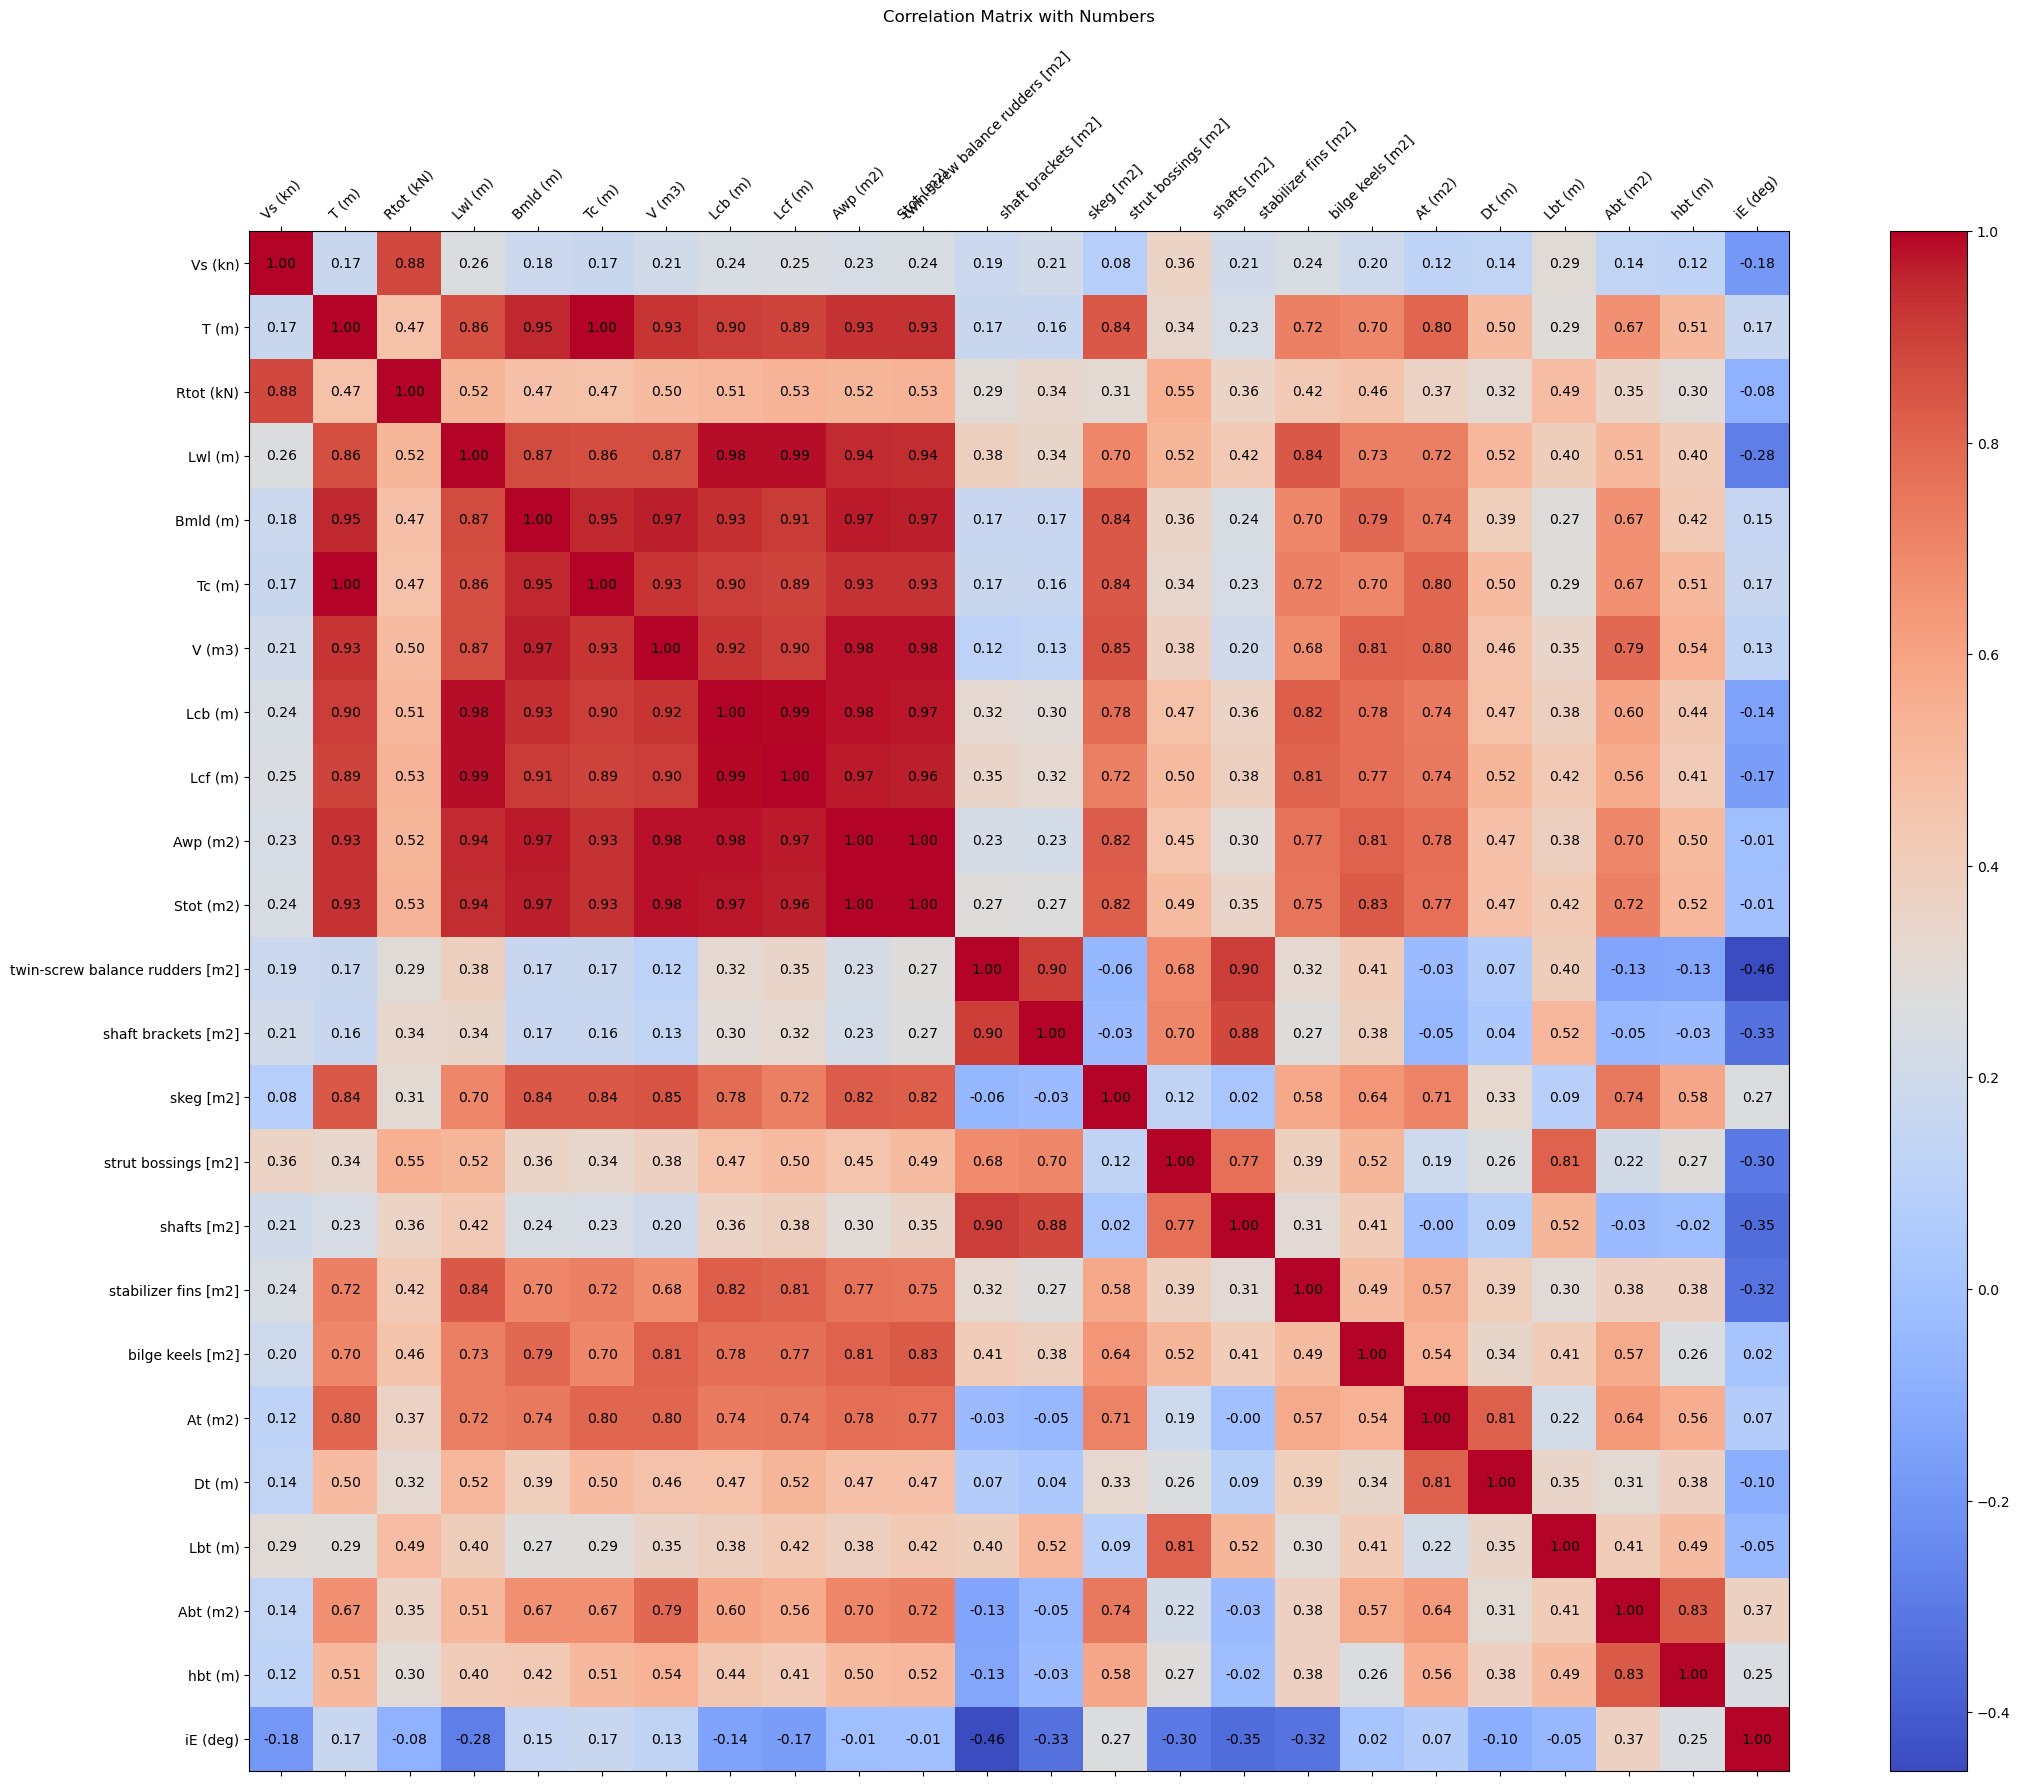

Index(['Vs (kn)', 'T (m)', 'Rtot (kN)', 'Lwl (m)', 'Bmld (m)', 'Tc (m)',
       'V (m3)', 'Lcb (m)', 'Lcf (m)', 'Awp (m2)', 'Stot (m2)',
       'twin-screw balance rudders [m2]', 'shaft brackets [m2]', 'skeg [m2]',
       'strut bossings [m2]', 'shafts [m2]', 'stabilizer fins [m2]',
       'bilge keels [m2]', 'At (m2)', 'Dt (m)', 'Lbt (m)', 'Abt (m2)',
       'hbt (m)', 'iE (deg)'],
      dtype='object')


In [11]:
# 3. The Correlation matrix will be shown below
var_main = relevant_columns
correlation_matrix(var_main, df_main)

print(relevant_columns)

In [12]:
# 4. Fill in the column names of the EXTRA variables you DO NOT want to include in the Selection Tool Analysis
# Only add variables to exclude that come from the listed variables printed above
extra_irrelevant_columns = df_main.columns.isin(['Rtot (kN)', 'iE (deg)'])

# Combined irrelevant columns
total_irrelevant_columns = irrelevant_columns + extra_irrelevant_columns
X_main = df_main.loc[:, ~(total_irrelevant_columns)]
X_main = sm.add_constant(X_main)

# 5. Fill in the column name of the variable Y you want to predict
y_main = df_main['Rtot (kN)']

# 6. Fill in the number of most important features you eventually want to select
#no_features = 5

## 3. Regression output results (please do not change anything here)

### SVM Linear + RFE

In [13]:
from sklearn.svm import LinearSVR
no_features = 3

# Function to select & fit with Support Vector Method (linear)
def SVM_linear_select_fit2(X, y, n_features = 2, split_data=False, test_size=0.3, random_state=42):
    
    # Optionally split dataset
    if split_data:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        print(f"Training Set Size: {X_train.shape[0]} rows")
        print(f"Test Set Size: {X_test.shape[0]} rows")    
    else:
        X_train, y_train = X, y
        X_test, y_test = None, None  # No test set in this case

    # Initialize the SVR model
    #svr = SVR(kernel='linear', C=1.0, epsilon=0.1)

    # Hyperparameter tuning using GridSearchCV
    param_grid = {
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1, 0.2]
    }
    svr = GridSearchCV(SVR(kernel='linear'), param_grid, cv=3, scoring='r2', n_jobs=-1) # n_jobs=-1 makes sure that work is divided in 8 CPU cores (computer chip workload)
    svr.fit(X_train, y_train)
    best_svr = svr.best_estimator_
    print("Best Hyperparameters:", best_svr.coef_)

    # Return values based on split mode
    if split_data:
        return X_train, X_test, y_train, y_test, best_svr
    else:
        return X_train, y_train, best_svr

In [14]:
X_train, X_test, y_train, y_test, best_svr = SVM_linear_select_fit2(X_main, y_main, split_data=True, n_features=no_features)

Training Set Size: 154 rows
Test Set Size: 66 rows
Best Hyperparameters: [[-4.44089210e-14  2.61771876e+01  3.19864138e+00 -3.65795524e+00
   8.02101259e-01  3.19864138e+00 -4.30134463e-03 -5.49141120e+00
   7.14654866e+00  3.56591653e-01 -5.62500269e-02 -3.16703831e-01
   1.57480649e+00 -7.08394814e-02  4.75701028e+00  1.82522963e-01
  -4.65024260e-01 -1.51598961e-02  5.25577451e+00  1.19062113e+00
   8.21861441e+00 -4.66298938e+00  7.40920793e+00]]
Best Hyperparameters: [[-4.44089210e-14  2.61771876e+01  3.19864138e+00 -3.65795524e+00
   8.02101259e-01  3.19864138e+00 -4.30134463e-03 -5.49141120e+00
   7.14654866e+00  3.56591653e-01 -5.62500269e-02 -3.16703831e-01
   1.57480649e+00 -7.08394814e-02  4.75701028e+00  1.82522963e-01
  -4.65024260e-01 -1.51598961e-02  5.25577451e+00  1.19062113e+00
   8.21861441e+00 -4.66298938e+00  7.40920793e+00]]


In [15]:
print(best_svr.get_params)
print(best_svr)

<bound method BaseEstimator.get_params of SVR(C=1, epsilon=0.01, kernel='linear')>
SVR(C=1, epsilon=0.01, kernel='linear')


In [16]:
def test_vervolg(X, X_train, X_test, y_train, best_svr, n_features = 2, split_data=False):
    best = SVR(kernel='linear', C=best_svr.C, epsilon=best_svr.epsilon)

    # Apply Recursive Feature Elimination (RFE)
    rfe = RFE(estimator=best, n_features_to_select=n_features)  # Select number of features
    rfe_model = rfe.fit(X_train, y_train)

    # Transform the dataset to only include selected features
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test) if split_data else None
    X_rfe = rfe.transform(X) if split_data else None

    # Selected features
    selected_features = rfe.support_
    print("Selected Features (after refit):", selected_features)

    # Map indices to actual feature names if available
    if hasattr(X_train, 'columns'):
        select_feat_SVM = X_train.columns[rfe.support_]
        print("Selected Features Names (after refit):", select_feat_SVM)

    # Ranking of features
    feature_ranking = rfe.ranking_
    print("Feature Ranking:", feature_ranking)

    # Fit the model to the transformed data
    svr_model = best.fit(X_train_rfe, y_train)

    # Check convergence
    if hasattr(svr_model, 'n_iter_'):
        print(f"Support Vector Method converged in {svr_model.n_iter_} iterations.")
    else:
        print("Convergence information not available.")

    # Return values based on split mode
    if split_data:
        return X_train, X_test, y_train, X_train_rfe, X_test_rfe, X_rfe, select_feat_SVM, svr_model
    else:
        return X_train_rfe, select_feat_SVM, svr_model

In [17]:
X_train, X_test, y_train, X_train_rfe, X_test_rfe, X_rfe, select_feat_SVM, svr_model = test_vervolg(X_main, X_train, X_test, y_train, best_svr, split_data=True, n_features=no_features)

: 

: 

In [ ]:
SVM_coeff = SVM_coefficients(svr_model)

# Prediction SVM results
y_pred_SVM = predict_SVM(X_test_rfe, y_test, svr_model)

# Visualize results
visualize_feature_importances_SVM(select_feat_SVM, SVM_coeff)
plot_pred_actual_results(y_test, y_pred_SVM)

# Cross-validation results
cross_validation(svr_model, X_rfe, y_main)

NameError: name 'svr_model' is not defined

In [ ]:
##############
# SVM linear: splitting of dataset
##############

# Select features SVM
X_train, X_test, y_train, y_test, X_train_rfe, X_test_rfe, X_rfe, select_feat_SVM, svr_model = SVM_linear_select_fit(X_main, y_main, split_data=True, n_features=no_features)
SVM_coeff = SVM_coefficients(svr_model)

# Prediction SVM results
y_pred_SVM = predict_SVM(X_test_rfe, y_test, svr_model)

# Visualize results
visualize_feature_importances_SVM(select_feat_SVM, SVM_coeff)
plot_pred_actual_results(y_test, y_pred_SVM)

# Cross-validation results
cross_validation(svr_model, X_rfe, y_main)

Training Set Size: 154 rows
Test Set Size: 66 rows


KeyboardInterrupt: 

In [ ]:
# Fill in the green numbers that correspond to the variable names in red preceding them:
############################

x_own_data = {
    'Vs (kn)': [12], 
    'Bmld (m)': [13.906],
    'strut bossings (m2)': [0],
    'At (m2)': [6.538],
    'Lbt (m)': [0]
}

# Create a DataFrame for X_new
x_own_svm = pd.DataFrame(x_own_data)
print(x_own_svm)

# Predict the target values (y) using the trained model
y_own_pred_SVM = svr_model.predict(x_own_svm)
print('This will be the predicted variable Y according to the trained Support Vector Model (linear):', y_own_pred_SVM)

   Vs (kn)  Bmld (m)  strut bossings (m2)  At (m2)  Lbt (m)
0       12    13.906                    0    6.538        0
This will be the predicted variable Y according to the trained Support Vector Model (linear): [25.89513288]


c:\Python\Anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Selected Features (after refit): [False  True  True False  True  True False False False False False False
 False False  True False False False False False False False False]
Selected Features Names (after refit): Index(['Vs (kn)', 'T (m)', 'Bmld (m)', 'Tc (m)', 'strut bossings [m2]'], dtype='object')
Feature Ranking: [18  1  1  6  1  1 16  7  5 12 15 13  8 14  1 17  9 10  2 11 19  4  3]
Support Vector Method converged in 307 iterations.
SVM coefficients (after refit): [26.31033664  6.20080076 11.54113643  6.20080076 11.40930342]
Mean Squared Error: 2013.54
R^2 Score: 0.87


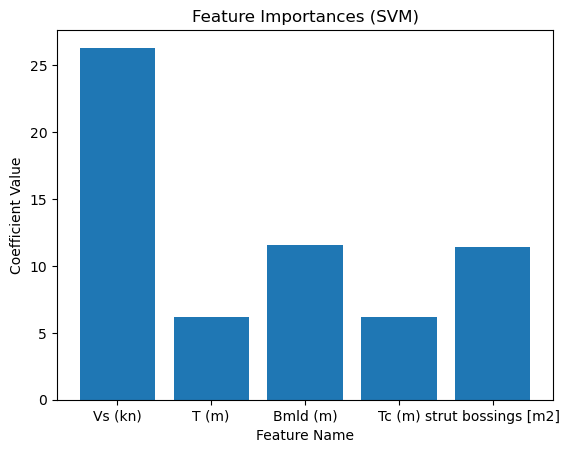

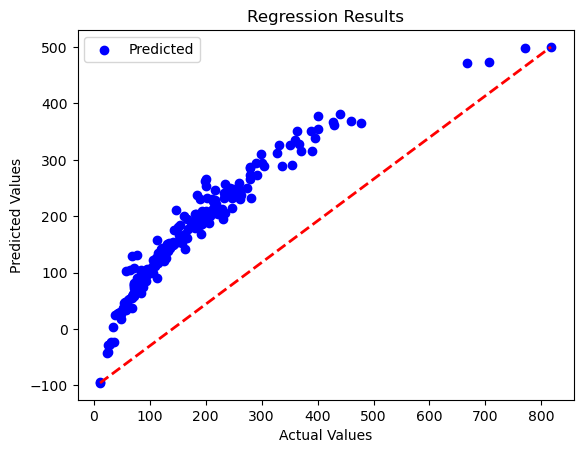

Cross-validated R^2 scores: [0.73672923 0.97818174 0.89221502 0.8934238  0.90352438]
Mean R^2 score: 0.8808148321315885


In [ ]:
##############
# SVM linear: no splitting of dataset
##############

# Select features SVM
X_train_rfe, select_feat_SVM, svr_model = SVM_linear_select_fit(X_main, y_main, n_features=no_features)
SVM_coeff = SVM_coefficients(svr_model)

# Prediction SVM results
y_pred_SVM = predict_SVM(X_train_rfe, y_main, svr_model)

# Visualize results
visualize_feature_importances_SVM(select_feat_SVM, SVM_coeff)
plot_pred_actual_results(y_main, y_pred_SVM)

# Cross-validation results
cross_validation(svr_model, X_train_rfe, y_main)

In [ ]:
print(select_feat_SVM)

Index(['Vs (kn)', 'T (m)', 'Bmld (m)', 'Tc (m)', 'strut bossings [m2]'], dtype='object')


In [ ]:
# Fill in the green numbers that correspond to the variable names in red preceding them:
############################

x_own_data = {
    'Vs (kn)': [12.0], 
    'Abt (m2)': [0],
    'Lcf (m)': [37.241],
    'Lwl (m)': [85.985],
    'V (m3)': [2338.342]
}

# Create a DataFrame for X_new
x_own_svm = pd.DataFrame(x_own_data)
print(x_own_svm)

# Predict the target values (y) using the trained model
y_own_pred_SVM = svr_model.predict(x_own_svm)
print('This will be the predicted variable Y according to the trained Support Vector Model (linear):', y_own_pred_SVM)

   Vs (kn)  Abt (m2)  Lcf (m)  Lwl (m)    V (m3)
0     12.0         0   37.241   85.985  2338.342
This will be the predicted variable Y according to the trained Support Vector Model (linear): [27540.95865352]


c:\Python\Anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


### Elastic Net = Lasso + Ridge (linear)

Training Set Size: 154 rows
Test Set Size: 66 rows
Best Hyperparameters: {'alpha': 0.1, 'l1_ratio': 0.1}

All Feature Coefficients (before refit):
const: 0.0000
Vs (kn): 28.3467
T (m): 5.2965
Lwl (m): -5.8693
Bmld (m): 4.5776
Tc (m): 5.2965
V (m3): -0.0137
Lcb (m): -1.4555
Lcf (m): 9.6994
Awp (m2): 0.1525
Stot (m2): 0.0506
twin-screw balance rudders [m2]: -0.9342
shaft brackets [m2]: 0.8894
skeg [m2]: -0.1191
strut bossings [m2]: 3.7853
shafts [m2]: 0.7252
stabilizer fins [m2]: -0.2393
bilge keels [m2]: 0.1151
At (m2): 6.2079
Dt (m): 0.2139
Lbt (m): 9.7474
Abt (m2): -6.3272
hbt (m): 11.5400
Convergence information not available.

Selected Features (after refit): ['Vs (kn)', 'T (m)', 'Bmld (m)', 'Tc (m)', 'Lbt (m)']
Selected Feature Coefficients (after refit): [27.79246588  7.45350715 13.97027305  7.45387184 16.76733488]
Elastic Net converged in 32 iterations.
Mean Squared Error: 1190.75
R^2 Score: 0.89


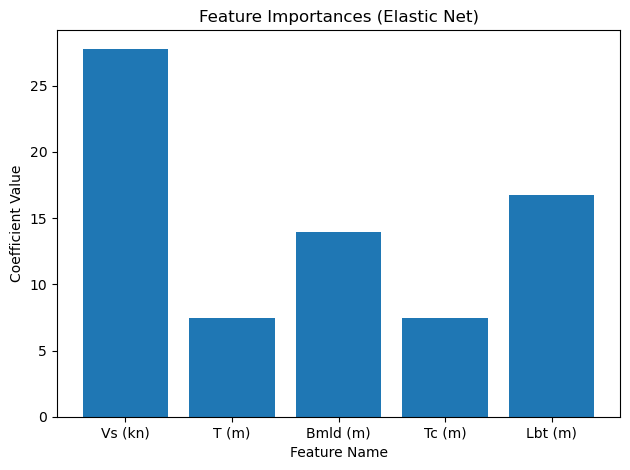

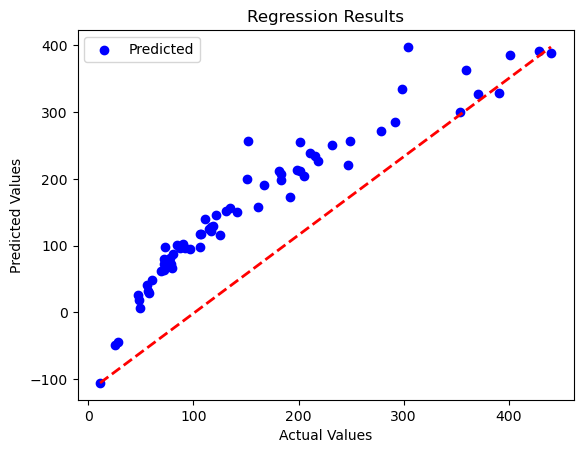

Cross-validated R^2 scores: [0.76935462 0.97007339 0.87545436 0.89893138 0.88103855]
Mean R^2 score: 0.8789704596816647


In [ ]:
##############
# EN: splitting dataset
##############

# Extract all feature coefficients EN
X_train, X_test, y_train, y_test, EN_hyperparams, EN_coeff_all, EN_coeff_nonzero, EN_model_all = elastic_net_fit_all(X_main, y_main, split_data=True)

# Refit with select number of most important features
select_feat_EN, X_train_rfe, X_test_rfe, X_rfe, EN_model_refit, EN_best_coeff = elastic_fit_select(X_main, y_main, EN_hyperparams, X_train=X_train, X_test=X_test, y_train=y_train, n_features=no_features)

# Prediction EN results
y_pred_EN = elastic_predict(X_test_rfe, y_test, EN_model_refit)

# Visualize results
visualize_feature_importances_EN(select_feat_EN, EN_best_coeff)
plot_pred_actual_results(y_test, y_pred_EN)

# Cross-validation results
cross_validation(EN_model_refit, X_rfe, y_main) # use selected features

In [ ]:
print(select_feat_EN)

['Vs (kn)', 'T (m)', 'Bmld (m)', 'Tc (m)', 'Lbt (m)']


In [ ]:
# Fill in the green numbers that correspond to the variable names in red preceding them:
############################

x_own_data = {
    'Vs (kn)': [12.0], 
    'T (m)': [3.82],
    'Bmld (m)': [13.906],
    'Tc (m)': [3.82],
    'Lbt (m)': [0]
}

# Create a DataFrame for X_new
x_own_svm = pd.DataFrame(x_own_data)
print(x_own_svm)

# Predict the target values (y) using the trained model
y_own_pred_SVM = svr_model.predict(x_own_svm)
print('This will be the predicted variable Y according to the trained Support Vector Model (linear):', y_own_pred_SVM)

   Vs (kn)  T (m)  Bmld (m)  Tc (m)  Lbt (m)
0     12.0   3.82    13.906    3.82        0
This will be the predicted variable Y according to the trained Support Vector Model (linear): [106.9911231]


c:\Python\Anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Best Hyperparameters: {'alpha': 0.1, 'l1_ratio': 0.9}

All Feature Coefficients (before refit):
const: 0.0000
Vs (kn): 27.9795
T (m): 3.2007
Lwl (m): -7.6320
Bmld (m): -0.0000
Tc (m): 3.2009
V (m3): -0.0204
Lcb (m): 0.0000
Lcf (m): 12.1555
Awp (m2): 0.0838
Stot (m2): 0.1492
twin-screw balance rudders [m2]: -1.2799
shaft brackets [m2]: 0.8700
skeg [m2]: -0.2813
strut bossings [m2]: 5.0448
shafts [m2]: 0.8832
stabilizer fins [m2]: -0.0788
bilge keels [m2]: -0.0181
At (m2): 5.8108
Dt (m): -0.1014
Lbt (m): 4.2401
Abt (m2): -8.9265
hbt (m): 17.1179
Convergence information not available.

Selected Features (after refit): ['Vs (kn)', 'T (m)', 'Tc (m)', 'strut bossings [m2]', 'Lbt (m)']
Selected Feature Coefficients (after refit): [27.56549848 31.31133532 31.22942197 15.72377626 10.97092237]
Elastic Net converged in 96 iterations.
Mean Squared Error: 1494.33
R^2 Score: 0.90


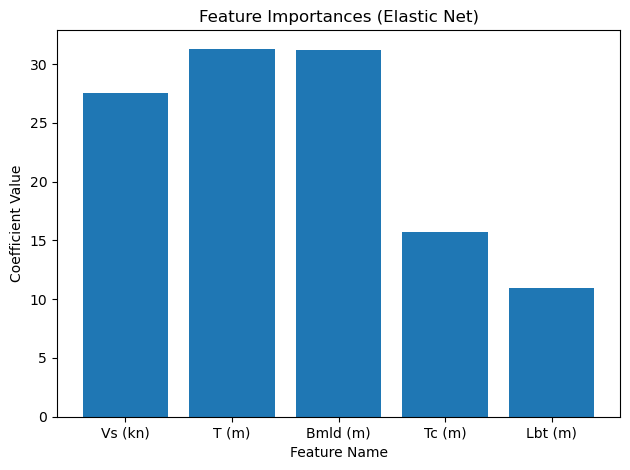

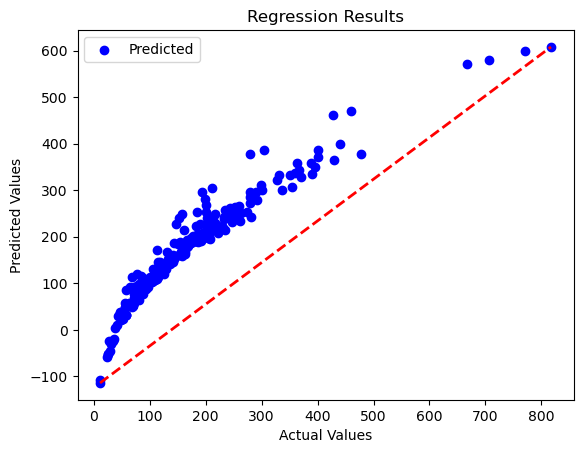

Cross-validated R^2 scores: [0.822514   0.9755143  0.8652329  0.90424607 0.89678933]
Mean R^2 score: 0.892859318544881


In [ ]:
##############
# EN: no splitting of dataset
##############

# Extract all feature coefficients EN
EN_hyperparams, EN_coeff_all, EN_coeff_nonzero, EN_model_all = elastic_net_fit_all(X_main, y_main)

# Refit with select number of most important features
selected_feat_EN, X_train_rfe, EN_model_refit, EN_best_coeff = elastic_fit_select(X_main, y_main, EN_hyperparams, n_features=no_features)
# More selected features leads to lower bias, but higher variance & prediction estimation error

# Prediction EN results
y_pred_EN = elastic_predict(X_train_rfe, y_main, EN_model_refit)

# Visualize results
visualize_feature_importances_EN(select_feat_EN, EN_best_coeff)
plot_pred_actual_results(y_main, y_pred_EN)

# Cross-validation results
cross_validation(EN_model_refit, X_train_rfe, y_main) # use selected features

### SVM with Radial Basis Kernel (nonlinear)

Training Set Size: 154 rows
Test Set Size: 66 rows
Best Hyperparameters: {'C': 10, 'epsilon': 0.2, 'gamma': 'scale'}
Selected Features Indices (after permutation importance): [ 6 10  9 17 15]
Selected Features Names (after permutation importance): Index(['V (m3)', 'Stot (m2)', 'Awp (m2)', 'bilge keels [m2]', 'shafts [m2]'], dtype='object')
Mean Squared Error: 8953.79
R^2 Score: 0.20


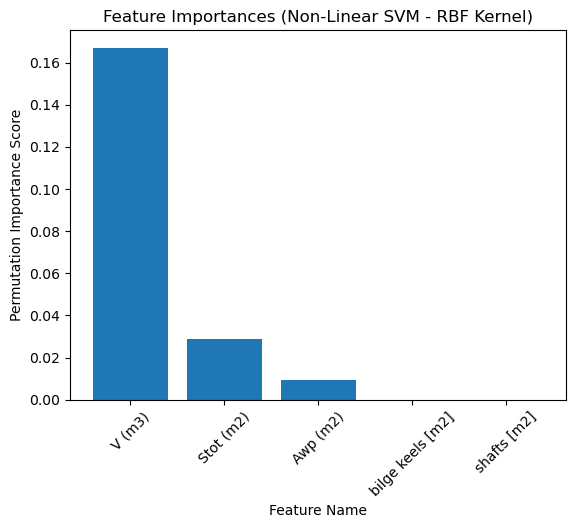

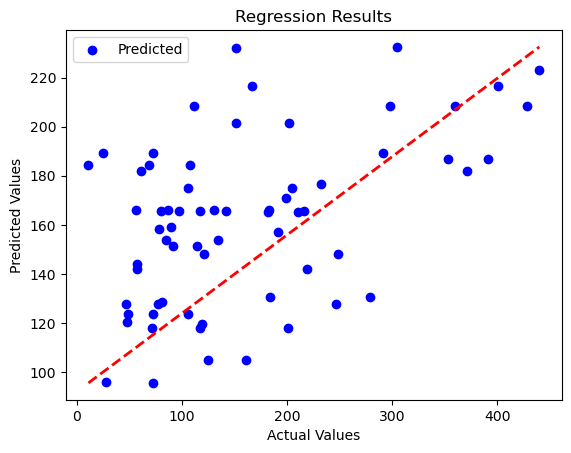

Cross-validated R^2 scores: [-0.0795787   0.12966844  0.12248689  0.1451086   0.04337857]
Mean R^2 score: 0.07221275994124421


In [ ]:
##############
# SVM nonlinear: splitting of dataset
##############

# Select features SVM
X_train, X_test, y_train, y_test, X_train_rfe, X_test_rfe, X_rfe, select_feat_SVM, svr_nonlinear, perm_importance = SVM_nonlinear_select_fit(X_main, y_main, split_data=True, n_features=no_features)

# Prediction SVM results
y_pred_SVM = predict_SVM_nonlinear(X_test_rfe, y_test, svr_nonlinear)

# Visualize results
visualize_feature_nonlinear_SVM(select_feat_SVM, perm_importance)
plot_pred_actual_results(y_test, y_pred_SVM)

# Cross-validation results
cross_validation(svr_nonlinear, X_rfe, y_main)

Best Hyperparameters: {'C': 10, 'epsilon': 0.01, 'gamma': 'scale'}
Selected Features Indices (after permutation importance): [ 6 10  9  1 15]
Selected Features Names (after permutation importance): Index(['V (m3)', 'Stot (m2)', 'Awp (m2)', 'Vs (kn)', 'shafts [m2]'], dtype='object')
Mean Squared Error: 11914.31
R^2 Score: 0.23


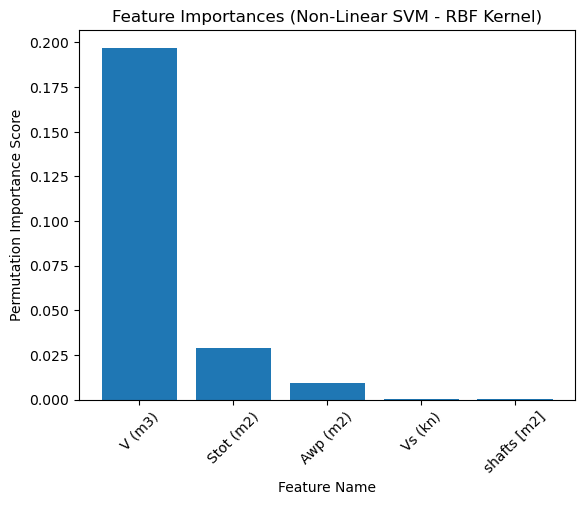

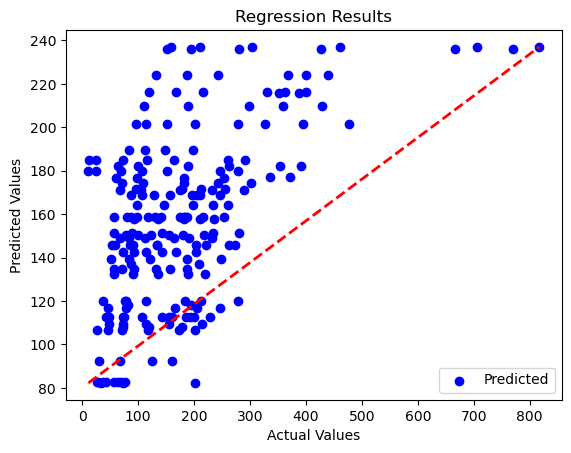

Cross-validated R^2 scores: [-0.07944798  0.12949263  0.12303041  0.14523473  0.04327836]
Mean R^2 score: 0.07231762900082857


In [ ]:
##############
# SVM linear: no splitting of dataset
##############

# Select features SVM
X_train_rfe, select_feat_SVM, svr_nonlinear, perm_importance = SVM_nonlinear_select_fit(X_main, y_main, n_features=no_features)

# Prediction SVM results
y_pred_SVM = predict_SVM_nonlinear(X_train_rfe, y_main, svr_nonlinear)

# Visualize results
visualize_feature_nonlinear_SVM(select_feat_SVM, perm_importance)
plot_pred_actual_results(y_main, y_pred_SVM)

# Cross-validation results
cross_validation(svr_nonlinear, X_train_rfe, y_main)

# To do

- running takes forever
- add own prediction to every method
- add RF
- check difference normalization or original data
- fix hypertuning problem for linear SVM
- think about missing values: 
want to clean all the way in the beginning? --> might remove rows of relevant selected features
or leave the missing values in place --> not sure if everything will run correctly
- explain variance-bias trade-off in manual + interpreting the correlation matrix better